In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [30]:
seed = 5555

In [3]:
def MAP_hpw(sx, dt):
    
    lam = np.log(np.sum(sx[1:] ** 2) / np.sum(sx[1:] * sx[:-1])) / dt

    I = 1 - np.exp(-2 * lam  *dt)
    D = lam * (np.sum((sx[1:] - sx[:-1] * np.exp(-lam*dt)) ** 2) / I / len(sx))

    return D, lam

In [4]:
## must do this because of the way random seeds are generated in numpy (sequentially random) 
def base_HPW_D(init_pos, t, D, well_pos, lambda_): 
    x0, y0 = init_pos 
    x_c, y_c = well_pos 
    x = [x0] 
    y = [y0]
    tau = np.diff(t) 
    for idx in range(len(t)):  
        mu_x = x_c + (x[-1] - x_c)*np.exp(-lambda_*tau) 
        sd_x = np.sqrt(D/lambda_ * (1. - np.exp(-2.*lambda_*tau))) 
        x.append((np.random.normal(loc=mu_x, scale=sd_x, size=1))[0]) 
        
        mu_y = y_c + (y[-1] - y_c)*np.exp(-lambda_*tau) 
        sd_y = np.sqrt(D/lambda_ * (1. - np.exp(-2.*lambda_*tau))) 
        y.append((np.random.normal(loc=mu_y, scale=sd_y, size=1))[0]) 
    return np.vstack((x,y)) 

### Effects of timestep

In [18]:
np.random.seed(seed) 
error_d, error_l = [], []
frame = []
for i in range(900): 
    init_pos = [0., 0.]
    t_ = np.linspace(0, 2, 1000-i) 
    D = 0.175 
    well_pos = [0, 0] 
    lambda_ = 255 
    baseHPW = base_HPW_D(init_pos, t_, D, well_pos, lambda_) 
    d_map, l_map = MAP_hpw(baseHPW[0], np.diff(t_)[0])
    error_d.append(d_map / D)
    error_l.append(l_map / lambda_)
    frame.append(2 / (1000-i))

C:\Users\jiayu\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


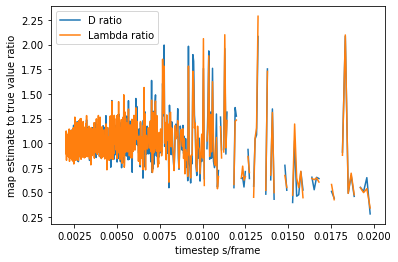

In [22]:
plt.plot(frame, error_d, label='D ratio')
plt.plot(frame, error_l, label='Lambda ratio')
plt.ylabel('map estimate to true value ratio')
plt.xlabel('timestep s/frame')
plt.legend();

### Effects of number of data points

In [29]:
np.random.seed(seed) 
init_pos = [0., 0.]
t_ = np.linspace(0, 2, 1000) 
D = 0.175 
well_pos = [0, 0] 
lambda_ = 255 
baseHPW = base_HPW_D(init_pos, t_, D, well_pos, lambda_) 
error_d, error_l, dp = [], [], []
for i in range(900): 
    d_map, l_map = MAP_hpw(baseHPW[1][:1000-i], np.diff(t_)[0])
    error_d.append(d_map / D)
    error_l.append(l_map / lambda_)
    dp.append(1000-i)

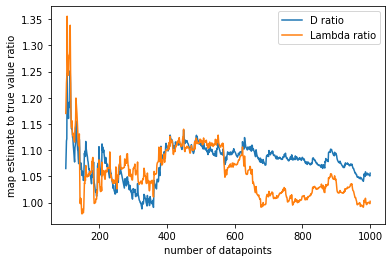

In [30]:
plt.plot(dp, error_d, label='D ratio')
plt.plot(dp, error_l, label='Lambda ratio')
plt.ylabel('map estimate to true value ratio')
plt.xlabel('number of datapoints')
plt.legend();

-----------------------

In [12]:
init_pos = [0, 0]
well_pos = [0, 0]

D_true = 0.175  # um^2/s
lambda_true = 250  #s^-1
n_data = 101

time_step1 = 0.08  # second/frame
time_step2 = 0.002  # second/frame
pixelToUm = 0.106  # um/pixel

t_1 = np.linspace(0, time_step1*(n_data-1), n_data) 
t_2 = np.linspace(0, time_step2*(n_data-1), n_data)

### Timestep = 0.08

D is 1.245995 pixel^2/frame, lambda is 20.000000 frame^-1


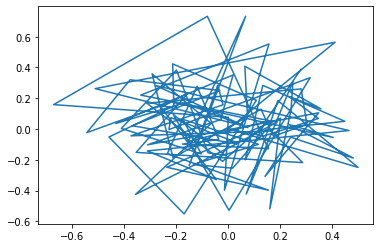

In [20]:
np.random.seed(seed) 
baseHPW_l = base_HPW_D(init_pos, t_1, D_true, well_pos, lambda_true) 
plt.plot(baseHPW_l[0]/pixelToUm, baseHPW_l[1]/pixelToUm)
D_scaled = D_true*time_step1/pixelToUm**2
lambda_scaled = lambda_true*time_step1
print('D is %f pixel^2/frame, lambda is %f frame^-1' %(D_scaled, lambda_scaled))

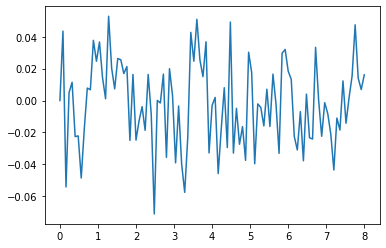

In [25]:
plt.plot(t_1, baseHPW_l[0][:-1]);

In [46]:
sx, sy = baseHPW_l[0]/pixelToUm, baseHPW_l[1]/pixelToUm
sdx, sdy = np.diff(baseHPW_l[0]/pixelToUm), np.diff(baseHPW_l[1]/pixelToUm)
sdt = np.ones((len(sdx), ))

In [51]:
model = pm.Model()

with model: 
    
    D = pm.Lognormal('D', 0, 1)
    k = pm.Lognormal('k', 2, 1)

#     D = pm.Lognormal('D', -3, 2)
#     k = pm.Lognormal('k', -1, 1)
    
    mean_x = (well_pos[0] - sx[:-1])*(1-tt.exp(-k*sdt))
    mean_y = (well_pos[1] - sy[:-1])*(1-tt.exp(-k*sdt))
    std = tt.sqrt(D*(1-tt.exp(-2*k*sdt))/k)

    like_x = pm.Normal('like_x', mu=mean_x, sd=std, observed=sdx)
    like_y = pm.Normal('like_y', mu=mean_y, sd=std, observed=sdy)

In [52]:
map_est = pm.find_MAP(model=model)
map_est

{'D_log__': array(-1.54491419),
 'k_log__': array(1.2089042),
 'D': array(0.21333018),
 'k': array(3.34981193)}

In [49]:
with model:
    trace = pm.sample(2000, tune=2000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, D]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
The acceptance probability does not match the target. It is 0.9116763084294678, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7210753678814373, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


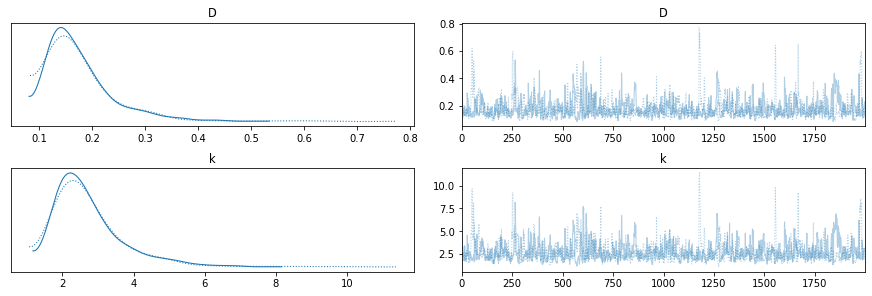

In [50]:
pm.traceplot(trace);

In [37]:
with model:
    trace = pm.sample(2000, tune=2000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, D]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.
The number of effective samples is smaller than 25% for some parameters.


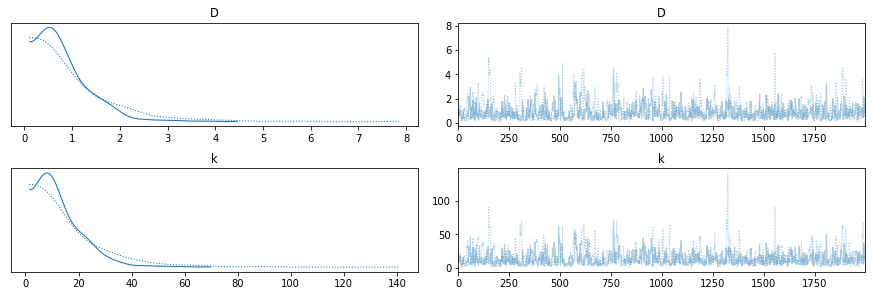

In [38]:
pm.traceplot(trace);

### Timestep = 0.002

D is 0.031150 pixel^2/frame, lambda is 0.500000 frame^-1


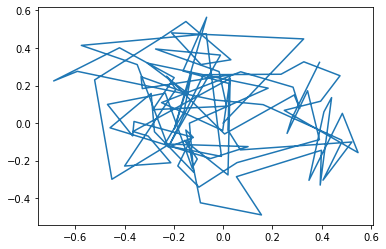

In [21]:
np.random.seed(seed) 
baseHPW_s = base_HPW_D(init_pos, t_2, D_true, well_pos, lambda_true) 
plt.plot(baseHPW_s[0]/pixelToUm, baseHPW_s[1]/pixelToUm)
D_scaled = D_true*time_step2/pixelToUm**2
lambda_scaled = lambda_true*time_step2
print('D is %f pixel^2/frame, lambda is %f frame^-1' %(D_scaled, lambda_scaled))

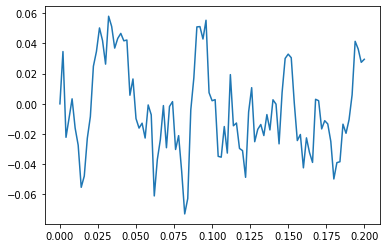

In [26]:
plt.plot(t_2, baseHPW_s[0][:-1]);

In [39]:
sx, sy = baseHPW_s[0]/pixelToUm, baseHPW_s[1]/pixelToUm
sdx, sdy = np.diff(baseHPW_s[0]/pixelToUm), np.diff(baseHPW_s[1]/pixelToUm)
sdt = np.ones((len(sdx), ))

In [40]:
model = pm.Model()

with model: 
    
    D = pm.Lognormal('D', -3, 2)
    k = pm.Lognormal('k', -1, 1)
    
    mean_x = (well_pos[0] - sx[:-1])*(1-tt.exp(-k*sdt))
    mean_y = (well_pos[1] - sy[:-1])*(1-tt.exp(-k*sdt))
    std = tt.sqrt(D*(1-tt.exp(-2*k*sdt))/k)

    like_x = pm.Normal('like_x', mu=mean_x, sd=std, observed=sdx)
    like_y = pm.Normal('like_y', mu=mean_y, sd=std, observed=sdy)

In [41]:
map_est = pm.find_MAP(model=model)
map_est

{'D_log__': array(-3.56664253),
 'k_log__': array(-0.96134515),
 'D': array(0.02825054),
 'k': array(0.38237818)}

In [42]:
with model:
    trace = pm.sample(2000, tune=2000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, D]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


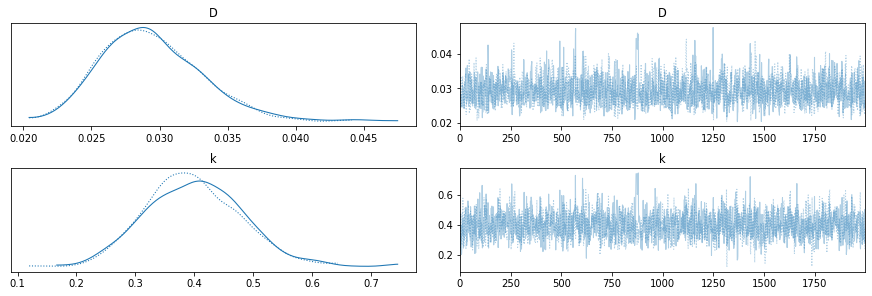

In [43]:
pm.traceplot(trace);

### Non-confined case

In [53]:
init_pos = [0, 0]
well_pos = [0, 0]

D_true = 0.175  # um^2/s
lambda_true = 0.25  #s^-1
n_data = 101

time_step1 = 0.08  # second/frame
time_step2 = 0.002  # second/frame
pixelToUm = 0.106  # um/pixel

t_1 = np.linspace(0, time_step1*(n_data-1), n_data)
t_2 = np.linspace(0, time_step2*(n_data-1), n_data)

D is 1.245995 pixel^2/frame, lambda is 0.020000 frame^-1


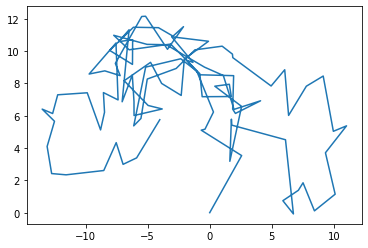

In [55]:
np.random.seed(seed) 
baseHPW_l = base_HPW_D(init_pos, t_1, D_true, well_pos, lambda_true) 
plt.plot(baseHPW_l[0]/pixelToUm, baseHPW_l[1]/pixelToUm)
D_scaled = D_true*time_step1/pixelToUm**2
lambda_scaled = lambda_true*time_step1
print('D is %f pixel^2/frame, lambda is %f frame^-1' %(D_scaled, lambda_scaled))

D is 0.031150 pixel^2/frame, lambda is 0.000500 frame^-1


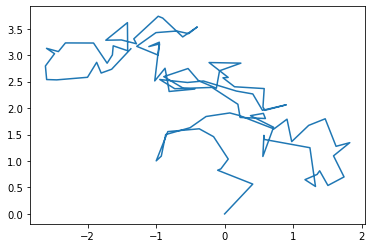

In [54]:
np.random.seed(seed) 
baseHPW_s = base_HPW_D(init_pos, t_2, D_true, well_pos, lambda_true) 
plt.plot(baseHPW_s[0]/pixelToUm, baseHPW_s[1]/pixelToUm)
D_scaled = D_true*time_step2/pixelToUm**2
lambda_scaled = lambda_true*time_step2
print('D is %f pixel^2/frame, lambda is %f frame^-1' %(D_scaled, lambda_scaled))

--------------------

In [56]:
init_pos = [0, 0]
well_pos = [0, 0]

D_true = 0.175  # um^2/s
lambda_true = 250  #s^-1
n_data = 101

time_step1 = 0.08  # second/frame
time_step2 = 0.002  # second/frame
pixelToUm = 0.106  # um/pixel

t_1 = np.linspace(0, time_step1*(n_data-1), n_data)
t_2 = np.linspace(0, time_step2*(n_data-1), n_data)

D is 1.245995 pixel^2/frame, lambda is 20.000000 frame^-1


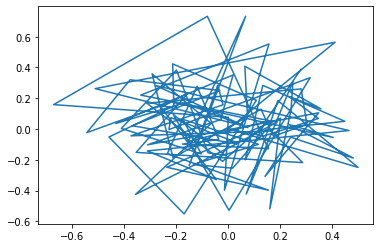

In [57]:
np.random.seed(seed) 
baseHPW_l = base_HPW_D(init_pos, t_1, D_true, well_pos, lambda_true) 
plt.plot(baseHPW_l[0]/pixelToUm, baseHPW_l[1]/pixelToUm)
D_scaled = D_true*time_step1/pixelToUm**2
lambda_scaled = lambda_true*time_step1
print('D is %f pixel^2/frame, lambda is %f frame^-1' %(D_scaled, lambda_scaled))